<!--<badge>--><a href="https://colab.research.google.com/github/huggingface/workshops/blob/main/fewshot-learning-in-production/setfit-optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Compressing SetFit Models with Knowledge Distillation and Quantization

[SetFit](https://github.com/huggingface/setfit) is a technique for few-shot text classification that uses contrastive learning to fine-tune Sentence Transformers in domains where little to no labeled data is available. It achieves comparable performance to existing state-of-the-art methods based on large language models, yet requires no prompts and is efficient to train (typically a few seconds on a GPU to minutes on a CPU).

In this workshop you'll learn how to apply two powerful techniques to compress SetFit models for faster inference & deployment:

* Knowledge distillation: use the information stored in the parameters of a _teacher model_ to guide the training of a smaller _student_. This typically results in a 2x reduction of model size, with little impact on accuracy.
* Quantization: convert the weights of the model from 32-bit floating point to 8-bit integer. This typically provides an additional 2x compression at the expense of a small loss in accuracy.

Along the way, you'll learn how to use two open-source libraries: 

* [SetFit](https://github.com/huggingface/setfit): a library built on [Sentence Transformers](https://sbert.net/) that implements the SetFit algorithm, along with techniques like knowledge distillation.
* [🤗 Optimum](https://github.com/huggingface/optimum): an extension of 🤗 Transformers, which provides a set of performance optimization tools enabling maximum efficiency to train and run models on targeted hardware.
* [🤗 Evaluate](https://github.com/huggingface/evaluate): a library that makes evaluating and comparing models and reporting their performance easier and more standardized.
* [Intel Neural Compressor](https://github.com/intel/neural-compressor): Intel's flagship library for applying compression algorithms to various frameworks like PyTorch and TensorFlow.


By the end of this session, you see knowledge distillation and quantization can significantly decrease model latency and size while keeping almost 100% of the full-precision model.

## 1. Setup development environment

Our first step is to install SetFit. Running the following cell will install all the required packages for us, including Intel Neural Compressor and 🤗 Optimum:

In [ ]:
%pip install setfit neural_compressor optimum[onnxruntime]==1.5.0 onnxruntime_extensions

While we're at it, let's turn off some of the warnings from the 🤗 Datasets library and the tokenizers:

In [1]:
import datasets

datasets.logging.set_verbosity_error()

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


To be able to share your model with the community, there are a few more steps to follow.

First, you have to store your authentication token from the Hugging Face Hub (sign up here if you haven't already!). To do so, execute the following cell and input an **access token with write permissions** associated with your account:

In [83]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 2. Create a performance benchmark

Before we train and optimize any models, let's define a performance benchmark that we can use to compare our models. In general, deploying ML models in production environments involves a tradeoff among several constraints:

* Model performance: how well does the model perform on a well crafted test set?
* Latency: how fast can our model deliver predictions?
* Memory: on what cloud instance or device can we store and load our model?

The class below defines a simplebenchmark that measure each quantity for a given SetFit model and test dataset:

In [2]:
from pathlib import Path
from time import perf_counter

import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm

metric = evaluate.load("accuracy")


class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self, query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.model([query])
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

## 3. Train teacher and student baselines

Before we optimize any models, let's train a few baselines as a point of reference. We'll use the [AG News](https://huggingface.co/datasets/ag_news) dataset, which is a collection of news articles categorised across 4 topics: world, sport, business, and sci/tech.

Let's start by loading the dataset from the Hub:

In [3]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

To simulate working in a few-shot regime, we'll randomly sample from the training set. We'll also need 1,000 unlabeled examples for the knowledge distillation step, so let's split the training data into separate splits to avoid any data leakage:

In [4]:
from setfit import sample_dataset

# Create 2 splits: one for few-shot training, the other for knowledge distillation
train_dataset = dataset["train"].train_test_split(seed=42)
# Sample 8 examples / class for fine-tuning
train_dataset_teacher = sample_dataset(train_dataset["train"])
# Select 1000 unlabeled examples for knowledge distillation
train_dataset_student = train_dataset["test"].select(range(1000))
# Define the test set for evaluation
test_dataset = dataset["test"]

In [5]:
# print dataset stats
print("Teacher dataset : ", train_dataset_teacher.shape )
print("Train dataset student : ", train_dataset_student.shape)

Teacher dataset :  (32, 2)
Train dataset student :  (1000, 2)


Now that we've got out training and test sets, let's train some SetFit models! With the `SetFitModel` and `SetFitTrainer` classes, this is quite simple:

In [ ]:
from setfit import SetFitModel, SetFitTrainer

# Load pretrained model from the Hub
teacher_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2"
)
# Create trainer
teacher_trainer = SetFitTrainer(
    model=teacher_model, 
    train_dataset=train_dataset_teacher
)
# Train!
teacher_trainer.train()

# Evaluate!
pb = PerformanceBenchmark(
    model=teacher_trainer.model, dataset=test_dataset, optim_type="MPNet (teacher)"
)
perf_metrics = pb.run_benchmark()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

Model size (MB) - 417.73
Accuracy on test set - 0.829
Average latency (ms) - 15.66 +\- 1.63


> dive deeper into the SitFit teacher model , what's in the boady and head

1. boady consists of sentence tranformer model `MPNetModel` , model output embeddings outputs from last pooling layer
2. classification head having basic sklearn logistic regression model

In [ ]:
teacher_trainer.model.model_body

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
teacher_trainer.model.model_head

LogisticRegression()

An accuracy of ~80% isn't too bad for just 8 labeled examples per class! Now let's see what happens if we train a much smaller model for comparison:

In [ ]:
baseline_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
baseline_trainer = SetFitTrainer(
    model=baseline_model, train_dataset=train_dataset_teacher
)
baseline_trainer.train()
pb = PerformanceBenchmark(baseline_trainer.model, test_dataset, "MiniLM-L3")
perf_metrics.update(pb.run_benchmark())

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

Model size (MB) - 66.36
Accuracy on test set - 0.751
Average latency (ms) - 5.06 +\- 0.60


## 4. Performance measurement on transfer learning / fine tunning method on MpNet model

> init the base mpnet model and tokenizer

In [ ]:
from transformers import AutoTokenizer, MPNetForSequenceClassification
import torch

# initialize the hardware type for traning
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initialize the mpnet base model and fine tune on the  given dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
model = MPNetForSequenceClassification.from_pretrained("microsoft/mpnet-base" , num_labels = 4)

transf_model = model
transf_model.to(device)

> set the intermediate layerto freeze state

In [19]:
transf_model.mpnet.embeddings.requires_grad= True
transf_model.mpnet.encoder.requires_grad= True

> MpNet model traning on given dataset

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModel

# init the perfroamnce metrix and tokenizer
accuracy = evaluate.load("accuracy")
tokenizer = AutoTokenizer.from_pretrained('microsoft/mpnet-base')

# apply text tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', 
                              truncation=True, 
                              return_tensors='pt' , max_length= 200 )

# tokenize the train and test datasets
train_tokenized_datasets = train_dataset_teacher.map(tokenize_function, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(predictions)
    return accuracy.compute(predictions=predictions, references=labels)


# define the mode traning arguments
training_args = TrainingArguments(
    output_dir="mpnet_samll_dataset",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

# initialize the trainer object
trainer = Trainer(
    model=transf_model,
    args=training_args,
    train_dataset= train_tokenized_datasets ,
    eval_dataset= test_tokenized_datasets ,
    compute_metrics=compute_metrics,
)
# run the model traning
trainer.train()

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--mpnet-base/snapshots/5b7474c98ab5f1801502f9d2348485acf4cbbe71/config.json
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "vocab_size": 30527
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--microsoft--mpnet-base/snapshots/5b7474c98ab5f1801502f9d23484

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.374406,0.394079
2,No log,1.360684,0.477500
3,No log,1.347000,0.550395
4,No log,1.333133,0.660921
5,No log,1.318643,0.712237
6,No log,1.304046,0.753158
7,No log,1.289598,0.772237
8,No log,1.275403,0.785263
9,No log,1.261632,0.795526
10,No log,1.248445,0.801184


The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[1 1 1 ... 1 2 1]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-2
Configuration saved in mpnet_samll_dataset/checkpoint-2/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-2/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[1 1 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-4
Configuration saved in mpnet_samll_dataset/checkpoint-4/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-4/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[3 1 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-6
Configuration saved in mpnet_samll_dataset/checkpoint-6/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-6/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[3 1 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-8
Configuration saved in mpnet_samll_dataset/checkpoint-8/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-8/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[3 0 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-10
Configuration saved in mpnet_samll_dataset/checkpoint-10/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-10/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[3 0 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-12
Configuration saved in mpnet_samll_dataset/checkpoint-12/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-12/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[3 3 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-14
Configuration saved in mpnet_samll_dataset/checkpoint-14/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-14/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 0 2 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-16
Configuration saved in mpnet_samll_dataset/checkpoint-16/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-16/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 0 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-18
Configuration saved in mpnet_samll_dataset/checkpoint-18/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-18/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 0 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-20
Configuration saved in mpnet_samll_dataset/checkpoint-20/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-20/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 0 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-22
Configuration saved in mpnet_samll_dataset/checkpoint-22/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-22/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-24
Configuration saved in mpnet_samll_dataset/checkpoint-24/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-24/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-26
Configuration saved in mpnet_samll_dataset/checkpoint-26/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-26/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 2 ... 1 2 2]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-28
Configuration saved in mpnet_samll_dataset/checkpoint-28/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-28/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-30
Configuration saved in mpnet_samll_dataset/checkpoint-30/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-30/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-32
Configuration saved in mpnet_samll_dataset/checkpoint-32/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-32/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-34
Configuration saved in mpnet_samll_dataset/checkpoint-34/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-34/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-36
Configuration saved in mpnet_samll_dataset/checkpoint-36/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-36/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-38
Configuration saved in mpnet_samll_dataset/checkpoint-38/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-38/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text. If text are not expected by `MPNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7600
  Batch size = 16


[2 3 0 ... 1 2 3]


Saving model checkpoint to mpnet_samll_dataset/checkpoint-40
Configuration saved in mpnet_samll_dataset/checkpoint-40/config.json
Model weights saved in mpnet_samll_dataset/checkpoint-40/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from mpnet_samll_dataset/checkpoint-40 (score: 1.170885682106018).


TrainOutput(global_step=40, training_loss=1.153365421295166, metrics={'train_runtime': 1783.719, 'train_samples_per_second': 0.359, 'train_steps_per_second': 0.022, 'total_flos': 65778945024000.0, 'train_loss': 1.153365421295166, 'epoch': 20.0})

In [17]:
!rm -rf "/content/mpnet_samll_dataset"

## 5. Benchmarking power of contrastive learning

### initialize senetence-transformer model and tokenizer

In [ ]:
# lets check the tsne distribution before the ST fine tune on contrastive learning and after contrassitive learning
from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-mpnet-base-v2').to(device)


### apply tokenizer and model to generate the embedding outputs

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

def generate_embeds( dataset ) :

  # initiate the dataloader
  news_dataloader = DataLoader( dataset , batch_size=32, shuffle=True)

  final_embeds , labels = [] , []

  for i_batch in news_dataloader :

    # Tokenize sentences
    encoded_input = tokenizer(i_batch['text'], 
                              padding=True, 
                              truncation=True, 
                              return_tensors='pt').to(device)

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    y = i_batch['label'].cpu().numpy().tolist()
    embeds  = sentence_embeddings.cpu().numpy().tolist()

    # extend the final placeholders
    final_embeds.extend( embeds )
    labels.extend( y )

  return np.array( final_embeds ) , np.array(labels)

> generate embeddings and labels

In [ ]:
# Sentences we want sentence embeddings for
raw_embeds , raw_labels =  generate_embeds( test_dataset )

> Tsne visualization

In [ ]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import matplotlib.pyplot as plt
import plotly.express as px

def Tsne_viz( embeds , labels ):
  # init tsne object
  tsne = TSNE(n_components=3, 
            verbose=1, 
            random_state=123)

  # transform the embeds into 2d space
  z = tsne.fit_transform( embeds )
  # init a df with final 2d vectors and labels
  df = pd.DataFrame()
  df["y"] = labels
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df["comp-3"] = z[:,2]

  fig = plt.figure(figsize=(10,10))
  # define seaborn  scatter plot
  # sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), s= 100 ,
  #               palette=sns.color_palette("hls", 4),
  #               data=df).set(title="AG News data T-SNE projection")

  # plot 3d scatter plot
  fig = px.scatter_3d(
    z , x=0, y=1, z=2,
    color=df.y , labels={'color': 'News Categories'}
  )
  fig.update_traces(marker_size=8)
  fig.show()


* vector space visualization of every class before setfit finetunning

In [ ]:
Tsne_viz( raw_embeds , raw_labels )

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7600 samples in 0.017s...
[t-SNE] Computed neighbors for 7600 samples in 4.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7600
[t-SNE] Computed conditional probabilities for sample 2000 / 7600
[t-SNE] Computed conditional probabilities for sample 3000 / 7600
[t-SNE] Computed conditional probabilities for sample 4000 / 7600
[t-SNE] Computed conditional probabilities for sample 5000 / 7600
[t-SNE] Computed conditional probabilities for sample 6000 / 7600
[t-SNE] Computed conditional probabilities for sample 7000 / 7600
[t-SNE] Computed conditional probabilities for sample 7600 / 7600
[t-SNE] Mean sigma: 0.966501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.918633
[t-SNE] KL divergence after 1000 iterations: 1.848709


<Figure size 720x720 with 0 Axes>

### generate embedding space using SetFit optimization

In [ ]:
def generate_setfit_embeds( model , dataset ):
    # initiate the dataloader
    news_dataloader = DataLoader( dataset, 
                                 batch_size=32,
                                 shuffle=True)

    final_embeds , labels = [] , []

    for i_batch in news_dataloader :

      # Compute token embeddings
      with torch.no_grad():
          model_output = model.encode( i_batch['text'] )

      y = i_batch['label'].cpu().numpy().tolist()
      embeds  = model_output.tolist()

      # extend the final placeholders
      final_embeds.extend( embeds )
      labels.extend( y )

    return np.array( final_embeds ) , np.array(labels)

In [ ]:
# generate embeds for setfit optimized teacher model
teacher_embeds , teacher_labels =  generate_setfit_embeds( teacher_trainer.model.model_body , test_dataset )

* vector space visualization after fine tunning mpnet model using setfit method

In [ ]:
Tsne_viz( teacher_embeds , teacher_labels )

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7600 samples in 0.005s...
[t-SNE] Computed neighbors for 7600 samples in 7.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7600
[t-SNE] Computed conditional probabilities for sample 2000 / 7600
[t-SNE] Computed conditional probabilities for sample 3000 / 7600
[t-SNE] Computed conditional probabilities for sample 4000 / 7600
[t-SNE] Computed conditional probabilities for sample 5000 / 7600
[t-SNE] Computed conditional probabilities for sample 6000 / 7600
[t-SNE] Computed conditional probabilities for sample 7000 / 7600
[t-SNE] Computed conditional probabilities for sample 7600 / 7600
[t-SNE] Mean sigma: 0.538711
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.388298
[t-SNE] KL divergence after 1000 iterations: 1.257854


<Figure size 720x720 with 0 Axes>

Hmm, although this model is ~3x faster at inference, the performance hit of ~7% is quite significant. Let's plot these results to visualise the two models:

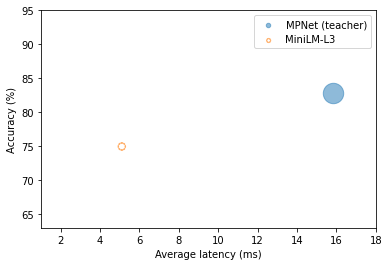

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker="$\u25CC$",
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                s=df_opt["size_mb"],
                label=idx,
                alpha=0.5,
            )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["MPNet (teacher)"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


plot_metrics(perf_metrics, "MiniLM-L3")

## 6. Train with knowledge distillation

We saw that the MiniLM model suffered a hit in performance due it's lower capacity. One way to improve the situation is with _knowledge distillation_, where we use the MPNet model as a "teacher" that guides the training of the smaller MiniLM model (check out Chapter 8 of the [_NLP with Transformers_](https://transformersbook.com/) book for an in-depth guide on knowledge distillation and other compression techniques). 

In SetFit, the way this works is by comparing the cosine similarities of the two models during the contrastive learning step, and computing the mean-squared error between them. This logic is wrapped in a handy `DistillationSetFitTrainer` which follows the same API as the standard `SetFitTrainer`. The main difference here is that we need to provide a dataset of unlabeled examples to perform the knowledge distillation step:

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 40000
  Num epochs = 1
  Total optimization steps = 2500
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

Model size (MB) - 66.36
Accuracy on test set - 0.830
Average latency (ms) - 5.20 +\- 0.62


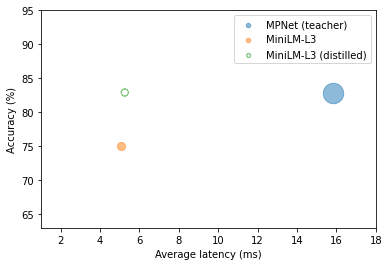

In [ ]:
from setfit import DistillationSetFitTrainer

student_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
student_trainer = DistillationSetFitTrainer(
    teacher_model=teacher_model,
    train_dataset=train_dataset_student,
    student_model=student_model,
)
student_trainer.train()

pb = PerformanceBenchmark(
    student_trainer.student_model, test_dataset, "MiniLM-L3 (distilled)"
)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, "MiniLM-L3 (distilled)")

Nice! We've recovered the same performance as the MPNet model, yet have ~3x decrease in latency from the smaller MiniLM checkpoint 🔥. Now that we have a good and efficient model, let's push it to the Hub so we can deploy it on [Inference Endpoints](https://huggingface.co/inference-endpoints)!

## 7. save the fine tunned model

Pushing the model to the Hub is a one-liner:

In [ ]:
student_trainer.save_pretrained("setfit-minilm-distilled")

## 8. Compressing further with ONNX and Intel Neural Compressor

The distilled model is likely suitable for most purposes, but sometimes you'll want to squeeze as much performance out of the model as possible. This is where a technique known as _quantization_ enters. The basic idea behind quantization is that we can “discretize” the floating-point values $f$ in each tensor by mapping their range $[f_{max}, f_{min}]$ into a smaller one $[q_{max}, q_{min}]$ of fixed-point numbers , and linearly distributing all values in between.

There are several ways to quantize a models' parameters, but the one we'll focus on today is _dynamic quantization_. Dynamic quantization converts the weights of a model from FP32 to INT8 post-training and does this conversion on-the-fly at inference time. This is one of the simplest quantization techniques and generally provides a ~2-3x reduction in latency.

In this section, we'll perform dynamic quantization with Intel Neural Compressor, and in pariticular on the ONNX representation of our SetFit model. Using ONNX turns out to be an effective way to optimally compress the model vs operating directly on PyTorch, so to get started let's export the model!

### Export the model body to ONNX

The first step is to export the model body (i.e. the Sentence Transformer) to ONNX format. We can do this easily in 🤗 Optimum, which provides autoclasses to load the model and save it to disk:

In [ ]:
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer

model_id = "setfit-minilm-distilled"
onnx_path = Path("onnx")
ort_model = ORTModelForFeatureExtraction.from_pretrained(
    model_id, from_transformers=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ort_model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

Now that the model is saved in ONNX format, we'll need an ONNX-variant of the `SetFitModel` class that allows us to train and run inference with it:

In [ ]:
from setfit.exporters.utils import mean_pooling
from sklearn.linear_model import LogisticRegression


class OnnxSetFitModel:
    def __init__(self, ort_model, tokenizer, model_head):
        self.ort_model = ort_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        )
        outputs = self.ort_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings)

    def __call__(self, inputs):
        return self.predict(inputs)

In [ ]:
onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer, student_model.model_head)
onnx_setfit_model(test_dataset["text"][:2])

array([2, 1])

### Apply dynamic quantization

In [ ]:
import functools

import evaluate
import onnxruntime
from optimum.pipelines import ORTModelForFeatureExtraction
from sklearn.linear_model import LogisticRegression

accuracy = evaluate.load("accuracy")


def eval_func(model, model_head=student_model.model_head):
    ort_model = ORTModelForFeatureExtraction.from_pretrained(onnx_path)
    ort_model.model = onnxruntime.InferenceSession(model.SerializeToString(), None)
    onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer, model_head)
    preds = []
    chunk_size = 100
    for i in tqdm(range(0, len(test_dataset["text"]), chunk_size)):
        preds.extend(
            onnx_setfit_model.predict(test_dataset["text"][i : i + chunk_size])
        )
    labels = test_dataset["label"]
    accuracy = metric.compute(predictions=preds, references=labels)
    return accuracy["accuracy"]

In [ ]:
def build_dynamic_quant_yaml():
    yaml = """
model:
  name: bert
  framework: onnxrt_integerops
  
device: cpu

quantization:
  approach: post_training_dynamic_quant

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open("MiniLM_L3_distilled_onnx_dynamic.yaml", "w", encoding="utf-8") as f:
        f.write(yaml)


build_dynamic_quant_yaml()

In [ ]:
from neural_compressor.experimental import Quantization, common

onnx_output_path = "onnx/model_quantized.onnx"
quantizer = Quantization("MiniLM_L3_distilled_onnx_dynamic.yaml")

In [ ]:
quantizer.model = common.Model("onnx/model.onnx")
quantizer.eval_func = functools.partial(eval_func)
quantized_model = quantizer()

2022-12-14 14:40:25 [INFO] Get FP32 model baseline.


  0%|          | 0/76 [00:00<?, ?it/s]

2022-12-14 14:41:10 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-production/nc_workspace/2022-12-14_14-40-23/./history.snapshot.
2022-12-14 14:41:10 [INFO] FP32 baseline is: [Accuracy: 0.8286, Duration (seconds): 45.5168]
2022-12-14 14:41:13 [INFO] |**********Mixed Precision Statistics*********|
2022-12-14 14:41:13 [INFO] +-----------------------+-------+------+------+
2022-12-14 14:41:13 [INFO] |        Op Type        | Total | INT8 | FP32 |
2022-12-14 14:41:13 [INFO] +-----------------------+-------+------+------+
2022-12-14 14:41:13 [INFO] |         Gather        |   5   |  3   |  2   |
2022-12-14 14:41:13 [INFO] |         MatMul        |   21  |  21  |  0   |
2022-12-14 14:41:13 [INFO] |    DequantizeLinear   |   3   |  3   |  0   |
2022-12-14 14:41:13 [INFO] | DynamicQuantizeLinear |   18  |  18  |  0   |
2022-12-14 14:41:13 [INFO] +-----------------------+-------+------+------+
2022-12-14 14:41:13 [INFO] Pass quantize model elapsed ti

  0%|          | 0/76 [00:00<?, ?it/s]

2022-12-14 14:41:54 [INFO] Tune 1 result is: [Accuracy (int8|fp32): 0.8282|0.8286, Duration (seconds) (int8|fp32): 40.9065|45.5168], Best tune result is: [Accuracy: 0.8282, Duration (seconds): 40.9065]
2022-12-14 14:41:54 [INFO] |**********************Tune Result Statistics**********************|
2022-12-14 14:41:54 [INFO] +--------------------+----------+---------------+------------------+
2022-12-14 14:41:54 [INFO] |     Info Type      | Baseline | Tune 1 result | Best tune result |
2022-12-14 14:41:54 [INFO] +--------------------+----------+---------------+------------------+
2022-12-14 14:41:54 [INFO] |      Accuracy      | 0.8286   |    0.8282     |     0.8282       |
2022-12-14 14:41:54 [INFO] | Duration (seconds) | 45.5168  |    40.9065    |     40.9065      |
2022-12-14 14:41:54 [INFO] +--------------------+----------+---------------+------------------+
2022-12-14 14:41:54 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-production/nc_w

In [ ]:
quantized_model.save("onnx/model_quantized.onnx")

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        preds = []
        chunk_size = 100
        for i in tqdm(range(0, len(self.dataset["text"]), chunk_size)):
            preds.extend(self.model.predict(self.dataset["text"][i : i + chunk_size]))
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

In [ ]:
ort_model = ORTModelForFeatureExtraction.from_pretrained(
    onnx_path, file_name="model_quantized.onnx"
)
onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer, student_model.model_head)

Model size (MB) - 17.13


  0%|          | 0/76 [00:00<?, ?it/s]

Accuracy on test set - 0.828
Average latency (ms) - 1.27 +\- 0.10


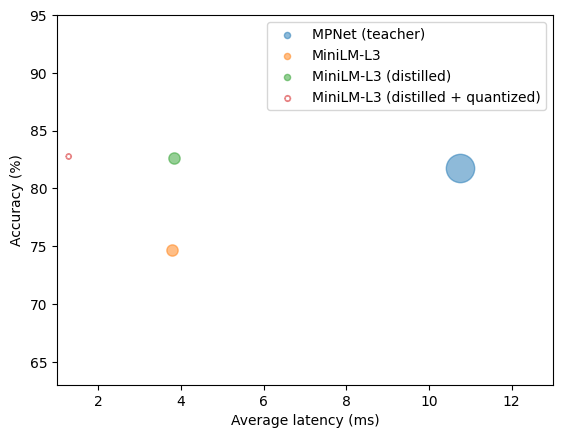

In [ ]:
pb = OnnxPerformanceBenchmark(
    onnx_setfit_model,
    test_dataset,
    "MiniLM-L3 (distilled + quantized)",
    model_path="onnx/model_quantized.onnx",
)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, "MiniLM-L3 (distilled + quantized)")

Wow, using Intel Neural Compressor shrunk our model to 17MB and even managed to preserve the performance of the original model!

## Price comparison

To get a sense of the value with using a highly compressed model vs the standard paradigm of a large language model (typically in the tens of billions of parameters range), consider the cost of deploying T-Few (the current SOTA) vs our compressed MiniLM model on Inference Endpoints. 

T-Few requires 1 80GB A100 to run, while the MiniLM model can run on the smallest CPU (1vCPU with 2GB RAM). According to the [pricing page](https://huggingface.co/docs/inference-endpoints/pricing) this is over a **100x reduction in cost** for comparable accuracy:

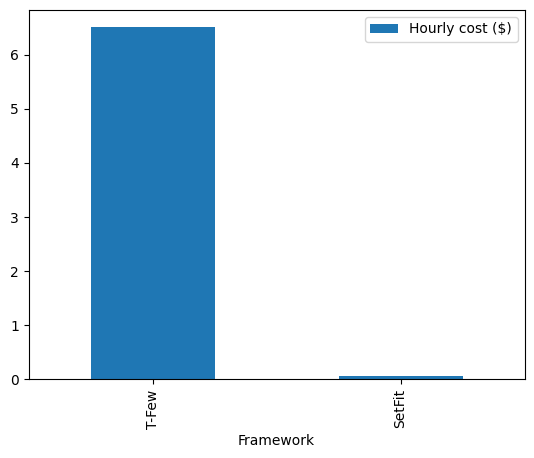

In [ ]:
import pandas as pd

cost_df = pd.DataFrame({"Framework": ["T-Few", "SetFit"], "Hourly cost ($)": [6.50, 0.06]})
cost_df.plot.bar(x="Framework", y="Hourly cost ($)");